In [61]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import TargetEncoder

import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

# EDA

In [62]:
""" 
Считываем данные и оформляем в DataFrame
"""
df_train = pd.read_csv('archive/train.csv').drop(['ID', 'Levy', 'Model'], axis=1)
df_train = df_train.sample(frac=0.3)
df_test = pd.read_csv('archive/test.csv').drop(['ID', 'Levy', 'Model'], axis=1)
df_test = df_test.sample(frac=0.3)

df_train

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2615,48610,TOYOTA,2012,Jeep,Yes,Hybrid,3.5,75000 km,6.0,Tiptronic,4x4,04-May,Left wheel,White,12
3258,35344,HYUNDAI,2015,Universal,Yes,Diesel,2.5,90660 km,4.0,Automatic,Front,04-May,Left wheel,White,4
446,17249,TOYOTA,2010,Sedan,No,Hybrid,1.8,256000 km,6.0,Automatic,Front,04-May,Left wheel,White,1
10921,13485,DODGE,2006,Minivan,No,LPG,3.3,135000 km,6.0,Automatic,Front,04-May,Left wheel,Blue,12
9452,54568,LEXUS,2013,Jeep,Yes,Petrol,4.6,202651 km,8.0,Automatic,4x4,04-May,Left wheel,Black,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,11290,HYUNDAI,2011,Sedan,Yes,Petrol,1.6,42211 km,4.0,Automatic,Front,04-May,Left wheel,Black,4
11581,21950,TOYOTA,2014,Coupe,No,Petrol,2.5,92000 km,4.0,Tiptronic,Front,02-Mar,Left wheel,Blue,6
1500,11604,FORD,2013,Sedan,Yes,Petrol,2,1000 km,4.0,Tiptronic,Front,04-May,Left wheel,White,6
13301,7213,NISSAN,2005,Hatchback,No,Petrol,1.4,139000 km,4.0,Automatic,Front,04-May,Right-hand drive,Yellow,4


Text(0.5, 0, 'Марка')

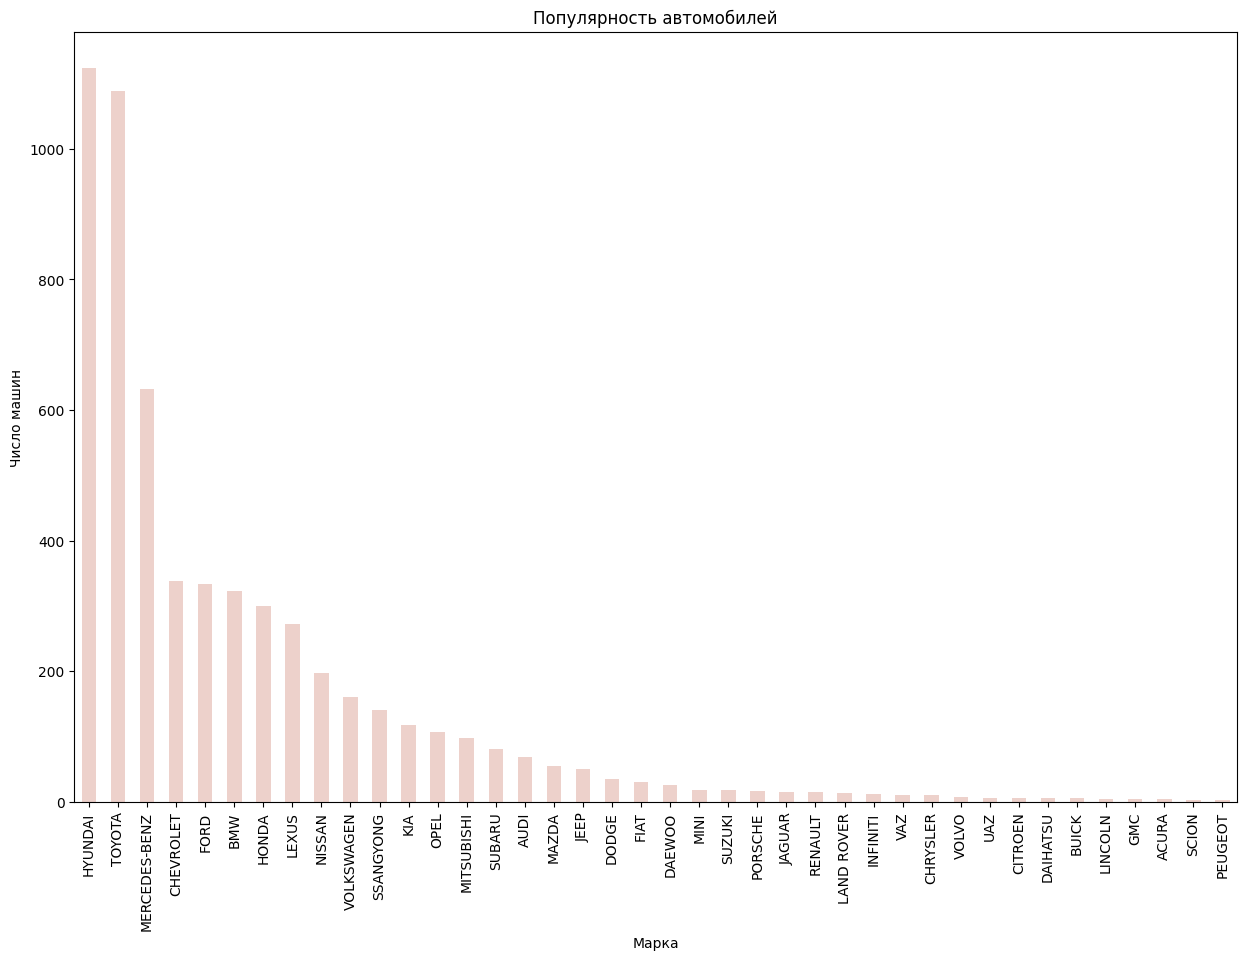

In [63]:
df_train.Manufacturer.value_counts().nlargest(40).plot(kind='bar', figsize=(15,10), colormap=sns.cubehelix_palette(as_cmap=True))
plt.title("Популярность автомобилей")
plt.ylabel('Число машин')
plt.xlabel('Марка')

In [64]:
""" 
Избавляемся от пробелов в датасете
"""

for column in df_train.columns:
    most_frequent_category = df_train[column].mode()[0]
    df_train[column] = df_train[column].replace(['NaN','?', ''], most_frequent_category)
    df_test[column] = df_test[column].replace(['NaN', '?', ''], most_frequent_category)
df_train

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2615,48610,TOYOTA,2012,Jeep,Yes,Hybrid,3.5,75000 km,6.0,Tiptronic,4x4,04-May,Left wheel,White,12
3258,35344,HYUNDAI,2015,Universal,Yes,Diesel,2.5,90660 km,4.0,Automatic,Front,04-May,Left wheel,White,4
446,17249,TOYOTA,2010,Sedan,No,Hybrid,1.8,256000 km,6.0,Automatic,Front,04-May,Left wheel,White,1
10921,13485,DODGE,2006,Minivan,No,LPG,3.3,135000 km,6.0,Automatic,Front,04-May,Left wheel,Blue,12
9452,54568,LEXUS,2013,Jeep,Yes,Petrol,4.6,202651 km,8.0,Automatic,4x4,04-May,Left wheel,Black,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,11290,HYUNDAI,2011,Sedan,Yes,Petrol,1.6,42211 km,4.0,Automatic,Front,04-May,Left wheel,Black,4
11581,21950,TOYOTA,2014,Coupe,No,Petrol,2.5,92000 km,4.0,Tiptronic,Front,02-Mar,Left wheel,Blue,6
1500,11604,FORD,2013,Sedan,Yes,Petrol,2,1000 km,4.0,Tiptronic,Front,04-May,Left wheel,White,6
13301,7213,NISSAN,2005,Hatchback,No,Petrol,1.4,139000 km,4.0,Automatic,Front,04-May,Right-hand drive,Yellow,4


In [65]:
""" 
Обрабатываем значения в столбце, которые численные, но с лишними подписями
"""
df_train['Engine volume'] = df_train['Engine volume'].apply(lambda x:float(re.sub('[^0-9]+', '', x)))
df_train['Mileage'] = df_train['Mileage'].apply(lambda x:int(re.sub('[^0-9]+', '', x)))
df_test['Engine volume'] = df_test['Engine volume'].apply(lambda x:float(re.sub('[^0-9]+', '', x)))
df_test['Mileage'] = df_test['Mileage'].apply(lambda x:int(re.sub('[^0-9]+', '', x)))


In [66]:
""" 
Изучаем датасет на выбросы
"""
df_train.describe()

,Price,Prod. year,Engine volume,Mileage,Cylinders,Airbags
count,5771.000000,5771.000000,5771.000000,5.771000e+03,5771.000000,5771.000000
mean,17298.419511,2010.914746,17.845088,1.124847e+06,4.584301,6.603535
std,18384.261318,5.926617,12.311564,3.752835e+07,1.233820,4.311302
min,3.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,5488.000000,2009.000000,3.000000,6.904400e+04,4.000000,4.000000
50%,13172.000000,2012.000000,18.000000,1.260000e+05,4.000000,6.000000
75%,22231.500000,2015.000000,25.000000,1.895300e+05,4.000000,12.000000
max,297930.000000,2020.000000,67.000000,2.147484e+09,16.000000,16.000000


In [67]:
""" 
Выясняем численные признаки
"""

numbers_features = []
for column in df_train.columns:
    if df_train[column].dtype !='object':
        numbers_features.append(column)
numbers_features

['Price', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

In [68]:
""" 
Удаляем выбросы с помощью квантиль .05-.95
"""
for feature in numbers_features:

    Q1 = df_train[feature].quantile(q = .05)
    Q3 = df_train[feature].quantile(q = .95)
    IQR = Q3 - Q1
    df_train = df_train[(df_train[feature] >= Q1 - 1.5 * IQR) & (df_train[feature] <= Q3 + 1.5 * IQR)] 

df_train = df_train.reset_index(drop = True)
df_train.shape

(5723, 15)

In [69]:
""" 
Создаем датасет только без категориальных признаков
"""
df_numbers_train = df_train[numbers_features]
df_numbers_test = df_test[numbers_features]

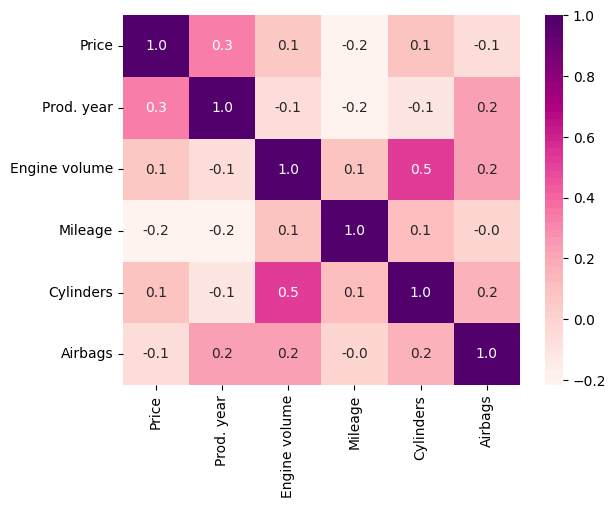

In [70]:
""" 
Визуализируем корреляцию между признаками
"""
sns.heatmap(df_numbers_train.corr(), annot = True, fmt=".1f", cmap= sns.color_palette("RdPu", 50))
plt.show()

# Задание №1, №2

### Построить линейную регрессию. Построить решение методом бустинга. Сравнить с линейной регрессией.

In [71]:
from sklearn import linear_model 
reg = linear_model.LinearRegression()

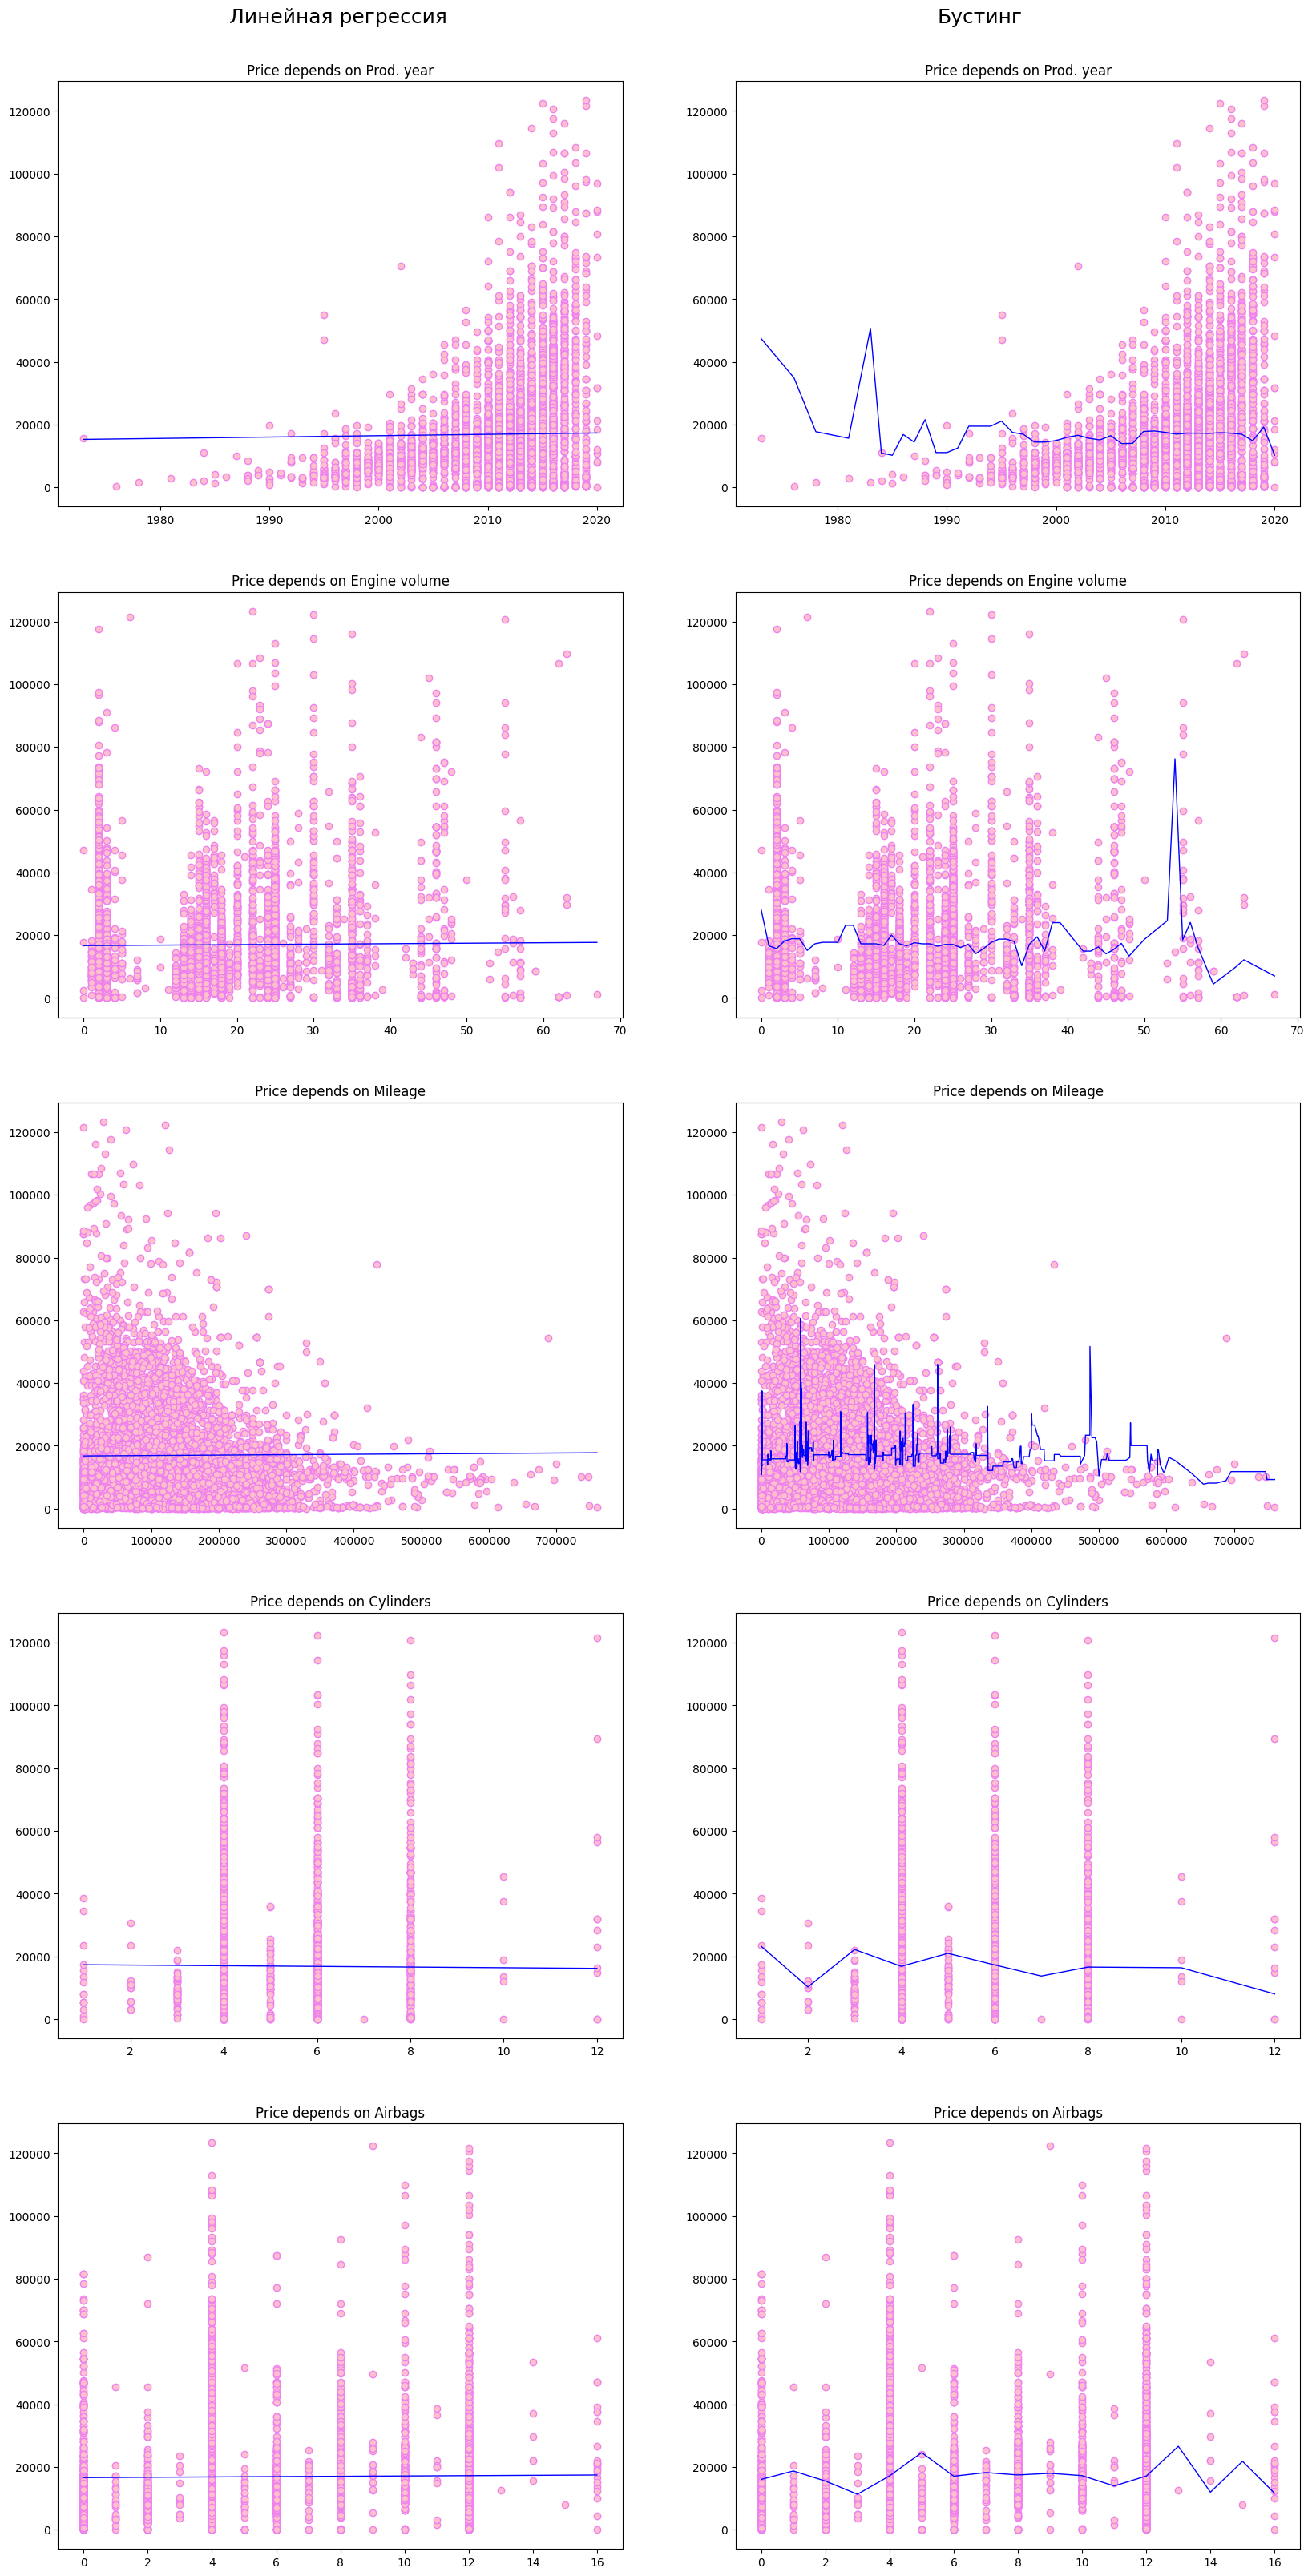

In [72]:
""" 
Сравниваем работу линейной регрессии с градиентным бустингом
"""
mse = {"LR":[], "GB":[]}

fig, axs = plt.subplots(nrows= len(numbers_features[1:]) , ncols= 2, figsize=(20, 40))
fig.text(s='Линейная регрессия', x=0.3, y=0.9, fontsize=18, ha='center', va='center')
fig.text(s='Бустинг', x=0.7, y=0.9, fontsize=18, ha='center', va='center')

for i, c in enumerate(df_numbers_test.columns[1:]):

    reg = linear_model.LinearRegression()

    x = df_numbers_train.sort_values(by=c)
    X = x[c].values.reshape(-1,1)
    reg.fit(X, df_numbers_train['Price'])
    y_pred = reg.predict(X)

    m = metrics.mean_squared_error(df_numbers_train['Price'], y_pred)
    mse['LR'].append(m)

    axs[i, 0].plot(X, y_pred, color="blue", linewidth=1)
    axs[i, 0].scatter(df_numbers_train[c], df_numbers_train['Price'], color="pink", edgecolors = 'violet')
    axs[i, 0].set_title("Price depends on " + c)

    gb_model = GradientBoostingRegressor()

    gb_model.fit(X, df_numbers_train['Price'])
    y_pred = gb_model.predict(X)
    
    m = metrics.mean_squared_error(df_numbers_train['Price'], y_pred)
    mse['GB'].append(m)

    axs[i, 1].plot(X, y_pred, color="blue", linewidth=1)
    axs[i, 1].scatter(df_numbers_train[c], df_numbers_train['Price'], color="pink", edgecolors = 'violet')
    axs[i, 1].set_title("Price depends on " + c)


# Задание №3

### Применить one hot и target encoding для категориальных признаков (взять данные, где такие признаки есть). Сравнить точность.


In [73]:
df_label = df_train
categorial_features = []

In [74]:
""" 
Применяем target encoding ко всем категориальным признакам
"""

df_category = df_train.select_dtypes([object])
X = TargetEncoder(target_type = 'continuous').fit_transform(df_category, df_train['Price'])

In [75]:
reg = linear_model.LinearRegression()
reg.fit(X, df_train['Price'])
reg_y_pred = reg.predict(X)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_model.fit(X, df_train['Price'])
gb_y_pred = gb_model.predict(X)

In [76]:
print('Test MSE LR ', metrics.mean_squared_error(reg_y_pred, y_pred))
print('Test MSE GB ',  metrics.mean_squared_error(gb_y_pred, y_pred))

Test MSE LR  54997521.449734986
Test MSE GB  71100769.016302


In [77]:
""" 
Применяем one hot encoding к всем категориальным признакам
"""
X = pd.get_dummies(df_category)
X

,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,Manufacturer_AUDI,Manufacturer_BMW,Manufacturer_BUICK,Manufacturer_CADILLAC,Manufacturer_CHEVROLET,Manufacturer_CHRYSLER,Manufacturer_CITROEN,Manufacturer_DAEWOO,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5718,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5719,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5720,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5721,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [78]:
reg = linear_model.LinearRegression()
reg.fit(X, df_train['Price'])
reg_y_pred = reg.predict(X)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_model.fit(X, df_train['Price'])
gb_y_pred = gb_model.predict(X)

In [79]:
print('Test MSE LR ', metrics.mean_squared_error(reg_y_pred, y_pred))
print('Test MSE GB ',  metrics.mean_squared_error(gb_y_pred, y_pred))

Test MSE LR  64635711.42087013
Test MSE GB  59547804.96686352


# Задание №4

### Визуализировать объекты (не обязательно для той же таблицы) в пространстве главных компонент.


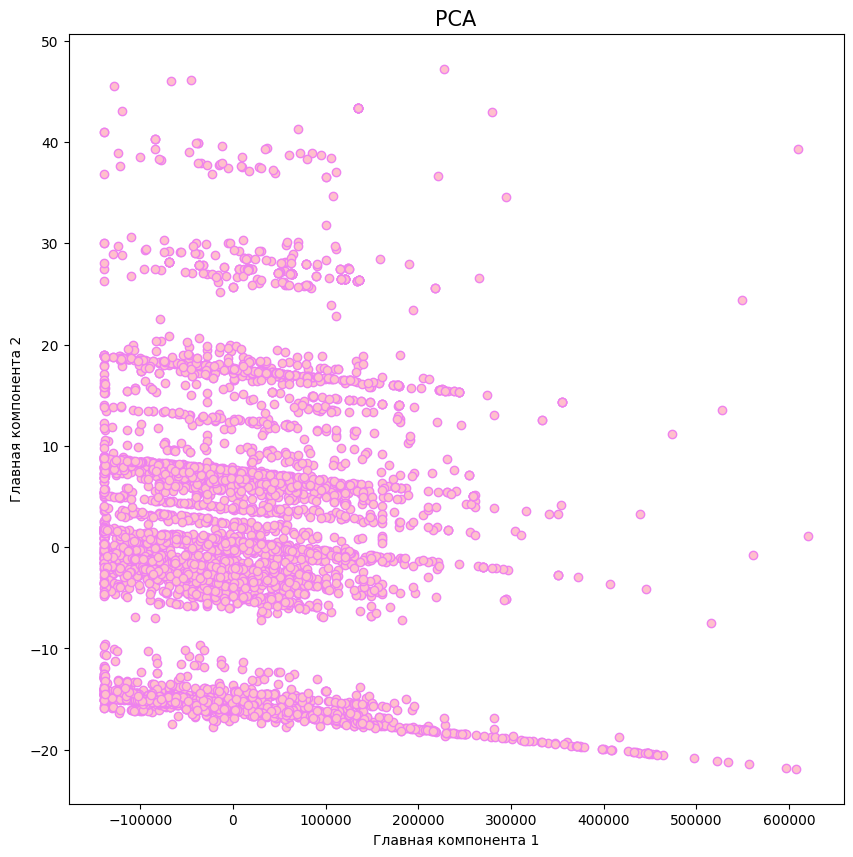

In [80]:
pca = PCA(2).fit_transform(df_numbers_train.drop(['Price'], axis = 1))    

plt.figure(figsize = (10, 10))
plt.scatter(pca[:, 0], pca[:, 1], color = 'pink', edgecolors = 'violet')

plt.title('PCA', fontsize = 15)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()

In [1]:
screrplot пару элементов визуализировать в пространстве точек объектов и пространтсве векторо признаков

SyntaxError: invalid syntax (1380349552.py, line 1)

In [ ]:
корреляционный график 